# Sentiment Analysis

In [1]:
from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding 
import matplotlib.pyplot as plt

import pandas as pd
import matplotlib.pyplot as plt
import string
import re
from collections import Counter
import numpy as np

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

#from tensorflow.keras import layers
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense
from keras.optimizers import Adam
from keras.layers import Dropout
from keras.optimizers import SGD, Adadelta, Adagrad
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import sys

Using TensorFlow backend.


In [2]:
# load the whole embedding into memory
embeddings_index = dict()
#first download the glove word emedding and then search for them
f = open('glove.6B//glove.6B.100d.txt',encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [3]:
df = pd.read_csv("//Users//saad//Saad//Education//Ryerson//DS8008 NLP//lab06//dataset.csv")
df.head(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
#shuffel data
np.random.seed(0)
df_shuffeld = df.sample(frac=1,random_state=0)
df_new = df_shuffeld.drop(columns=['id'])
df_new.head(5)
df_new.dtypes

comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
dtype: object

In [5]:
#text cleaning
sys.setrecursionlimit(5000)

punctuationList=list(string.punctuation)
def myTokenizer_modified(doc):
    stemmer = PorterStemmer()
    #return_doc = []
    #for doc in textData:
    #doc = str(doc)
    stemmedWords=[stemmer.stem(w) for w in nltk.word_tokenize(doc) if w not in punctuationList]
    new_text = ' '.join(stemmedWords)
    #return_doc.append(new_text)
     
    return  new_text

df_new['comment_text_clean'] = df_new.comment_text.apply(lambda x: myTokenizer_modified(x))
df_new.head(5)



,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_text_clean
74251,"""\nI haven't paraphrased you at all, Gary. Yo...",0,0,0,0,0,0,`` I have n't paraphras you at all gari you co...
131406,I BLOCKED REVERS! I BLOCKED REVERS! I BLOCKED ...,1,0,0,0,0,0,I block rever I block rever I block rever I bl...
120969,I'm sorry. I'd like to unreservedly retract my...,0,0,0,0,1,0,I 'm sorri I 'd like to unreservedli retract m...
121827,I don't know if this is exactly like the Press...,0,0,0,0,0,0,I do n't know if thi is exactli like the press...
4771,"Thank you all, we'll all improve the Wikipedia...",0,0,0,0,0,0,thank you all we 'll all improv the wikipedia ...


In [6]:
array_comments = df_new['comment_text_clean'].values
array_comments_clean = array_comments.astype(str)
#array_comments = np.array2string(array_comments)
array_all_labels = df_new[['toxic','severe_toxic','obscene','threat','insult','identity_hate']].values
#array_comments_clean = myTokenizer_modified(array_comments)
print(array_comments_clean.shape)
print(array_all_labels.shape)

(159571,)
(159571, 6)


In [7]:
t_comments = Tokenizer()
t_comments.fit_on_texts(array_comments_clean)
vocab_size_comments = len(t_comments.word_index) + 1
encoded_comments = t_comments.texts_to_sequences(array_comments_clean)

max_len = 0
for doc in encoded_comments:
    len_of_doc = len(doc)
    if len_of_doc > max_len:
        max_len = len_of_doc

padded_comments = pad_sequences(encoded_comments, maxlen=max_len, padding='post')
print ("shape padded_comments %d,%d" % (padded_comments.shape[0],padded_comments.shape[1]))

shape padded_comments 159571,1403


In [8]:
# Initialize a matrix with zeros having dimensions equivalent to vocab size and 100
embedding_matrix_comments = zeros((vocab_size_comments, 100))
# Iterate over words and their indexes in our data
for word, idx_word in t_comments.word_index.items():
    # get embedding vectors for the word in our training data
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        #insert it in the matrix at the index of the word
        embedding_matrix_comments[idx_word] = embedding_vector
print ("shape embedding_matrix_comments %d,%d" % (embedding_matrix_comments.shape[0],embedding_matrix_comments.shape[1]))

shape embedding_matrix_comments 165822,100


In [9]:
#split data
comments_train, comments_test, label_train, label_test = train_test_split(padded_comments, array_all_labels, train_size=0.8)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [10]:
# define model
model_comments = Sequential()
e = Embedding(vocab_size_comments, 100, weights=[embedding_matrix_comments], input_length=max_len, trainable=False)
model_comments.add(e)
model_comments.add(Flatten())
model_comments.add(Dense(80, activation='relu'))
model_comments.add(Dense(50, activation='relu'))
model_comments.add(Dense(30, activation='relu'))
#model_comments.add(Dense(20, activation='relu'))
model_comments.add(Dense(array_all_labels.shape[1], activation='sigmoid'))
# compile the model
model_comments.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['acc'])
# summarize the model
print(model_comments.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1403, 100)         16582200  
_________________________________________________________________
flatten_1 (Flatten)          (None, 140300)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 80)                11224080  
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 186       
Total params: 27,812,046
Trainable params: 11,229,846
Non-trainable params: 16,582,200
_______________________________________________________

In [12]:
# Fit the model
history_comments = model_comments.fit(comments_train, label_train, epochs=3, batch_size=5000, validation_data=(comments_test, label_test))




Train on 127656 samples, validate on 31915 samples
Epoch 1/3
127656/127656 [==============================] - 150s 1ms/step - loss: 0.2043 - acc: 0.9633 - val_loss: 0.1921 - val_acc: 0.9633
Epoch 2/3
127656/127656 [==============================] - 150s 1ms/step - loss: 0.1845 - acc: 0.9633 - val_loss: 0.1786 - val_acc: 0.9633
Epoch 3/3
127656/127656 [==============================] - 149s 1ms/step - loss: 0.1739 - acc: 0.9633 - val_loss: 0.1704 - val_acc: 0.9634


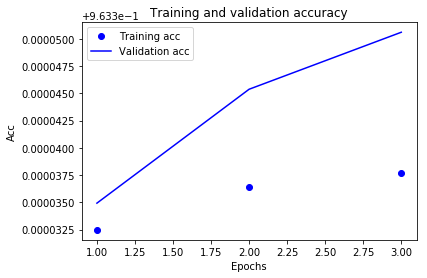

In [13]:
plt.clf()
acc = history_comments.history['acc']
epochs = range(1, len(acc) + 1)
val_acc = history_comments.history['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [14]:
predictions = model_comments.predict(comments_test)
predictions[predictions>=0.5] = 1
predictions[predictions<0.5] = 0
predictions.shape

(31915, 6)

In [15]:
#acc calc
row_acc2 = []

for row in range(predictions.shape[0]):
    acc_per_row = 0
    sum_num_of_labels = np.sum(label_test[row])
    sum_num_of_pred = np.sum(predictions[row])
    for col in range(predictions.shape[1]):
        
        if predictions[row][col] == label_test[row][col] and label_test[row][col] == 1:
            acc_per_row += 1
        
    if sum_num_of_labels == 0:
        if sum_num_of_pred == 0:
            row_acc2.append(1)
        else:
            row_acc2.append(0)
    else:
        row_acc2.append(acc_per_row/sum_num_of_labels)
    
    
col_acc = []
for col in range(predictions.shape[1]):
    acc_per_col = 0
    sum_num_of_labels_col = np.sum(label_test[:,col])
    sum_num_of_pred_col = np.sum(predictions[:,col])
    for row in range(predictions.shape[0]):
        
        if predictions[row][col] == label_test[row][col] and label_test[row][col] == 1:
            acc_per_col += 1
            
    if sum_num_of_labels_col == 0:
        if sum_num_of_pred_col == 0:
            col_acc.append(1)
        else:
            col_acc.append(0)
    else:
        col_acc.append(acc_per_col/sum_num_of_labels_col)
    
avg_acc = sum(row_acc2) / len(row_acc2) 
print("avg accuracy: %s" % avg_acc)
print ("min accuracy: %s" % min(row_acc2))
print ("max accuracy: %s" % max(row_acc2))

avg accuracy: 0.8989033369888767
min accuracy: 0.0
max accuracy: 1
